In [1]:
import json
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from training_data_generation import model_ready_data

# Data Analysis

In [31]:
X = pd.read_csv("data/X.csv")
y = pd.read_csv("data/y.csv")

In [32]:
df = X.join(y)
df.shape

(69820, 94)

In [33]:
X.columns.values

array(['rsi_5', 'rsi_5-1', 'rsi_5-5', 'rsi_5-20', 'rsi_14', 'rsi_14-1',
       'rsi_14-5', 'rsi_14-20', 'rsi_30', 'rsi_30-1', 'rsi_30-5',
       'rsi_30-20', 'ma_5', 'ma_5-1', 'ma_5-5', 'ma_5-20', 'ma_20',
       'ma_20-1', 'ma_20-5', 'ma_20-20', 'ma_50', 'ma_50-1', 'ma_50-5',
       'ma_50-20', 'ma_100', 'ma_100-1', 'ma_100-5', 'ma_100-20', 'ema_5',
       'ema_5-1', 'ema_5-5', 'ema_5-20', 'ema_20', 'ema_20-1', 'ema_20-5',
       'ema_20-20', 'ema_50', 'ema_50-1', 'ema_50-5', 'ema_50-20',
       'ema_100', 'ema_100-1', 'ema_100-5', 'ema_100-20', 'macd',
       'macd-1', 'macd-5', 'macd-20', 'macd_signal', 'macd_signal-1',
       'macd_signal-5', 'macd_signal-20', 'so_5', 'so_5-1', 'so_5-5',
       'so_5-20', 'so_14', 'so_14-1', 'so_14-5', 'so_14-20', 'so_30',
       'so_30-1', 'so_30-5', 'so_30-20', 'atr_5', 'atr_5-1', 'atr_5-5',
       'atr_5-20', 'atr_14', 'atr_14-1', 'atr_14-5', 'atr_14-20',
       'atr_30', 'atr_30-1', 'atr_30-5', 'atr_30-20', 'adx_5', 'adx_5-1',
       'adx_5-5',

0.0016621931360238627
0.08680567959150588 [-15.22037646]


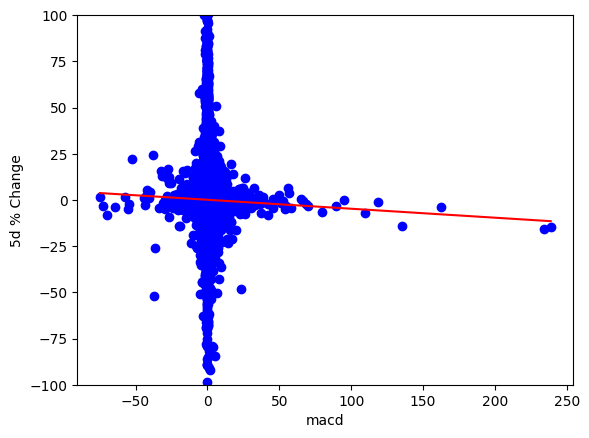

In [84]:
col = "macd"
resp = "5d"
temp = df.sort_values(by=col)

_, p = pearsonr(temp[col], temp[resp])
print(p)

lm = LinearRegression()
lm_x = np.expand_dims(np.array(temp[col].tolist()), axis=1)
lm.fit(lm_x, temp[resp])
lm_preds = lm.predict(lm_x)
print(lm.intercept_, lm.coef_*(temp[col].max() - temp[col].min()))

plt.plot(temp[col], temp[resp], "bo")
plt.plot(temp[col], lm_preds, "r")
plt.xlabel(col)
plt.ylabel(resp + " % Change")

plt.ylim(-100, 100)
plt.show()

In [67]:
col1, col2 = "macd", "macd-5"
_, p = pearsonr(temp[col1], temp[resp])
print(p)
_, p = pearsonr(temp[col2], temp[resp])
print(p)
_, p = pearsonr(temp[col1] - temp[col2], temp[resp])
print(p)
_, p = pearsonr(temp[col1]/temp[col2], temp[resp])
print(p)

0.0016621931360238627
0.01263682334512693
0.017713116211973728


ValueError: array must not contain infs or NaNs

# Model Analysis

In [ ]:
def build_model(dense_architecture, input_shape, learning_rate):
    model = Sequential()
    
    # dense layers
    for i in range(len(dense_architecture)):
        width = dense_architecture[i]
        if i == 0:
            model.add(Dense(width, activation="relu", input_shape=input_shape))
        else:
            model.add(Dense(width, activation="relu"))
    
    # add output layer
    model.add(Dense(1, activation="linear"))

    # compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="MeanSquaredError",
                optimizer=optimizer,
                metrics=["MeanAbsoluteError"])
    
    return model

In [ ]:
with open("models/nn_1d.json") as f:
    hp = json.load(f)

In [ ]:
hp

In [ ]:
X_train, X_val, y_train, y_val, auxiliary_train, auxiliary_val = model_ready_data("data/X.csv", "data/y.csv")
input_shape = X_train[0].shape

In [ ]:
final_architecture = [int(hp["min_width"])*(2**i) for i in range(int(hp["num_layers"]))]
model = build_model(final_architecture, input_shape, hp["learning_rate"])
model.load_weights("models/nn_1d.h5")

In [ ]:
preds = model.predict(X_val)
errors = (preds[:, 0] - y_val[:, 0])
mse = np.mean(errors**2)
mae = np.mean(abs(errors))
mse, mae

In [ ]:
dates = auxiliary_val[:, 0]
total_revenue = auxiliary_val[:, 1]
revenue_per_share = auxiliary_val[:, 2]

In [ ]:
results = pd.DataFrame()
results["preds"] = preds[:, 0]
results["true"] = y_val[:, 0]
results["error"] = errors
results["mae"] = mae
results["date"] = dates
results["total_rev"] = total_revenue

In [ ]:
def cross_with_true(df, other_column, num_cuts):
    percentiles = []
    for i in range(num_cuts):
        next_percentile = np.nanpercentile(df[other_column], i*100/(num_cuts))
        if next_percentile not in percentiles:
            percentiles.append(round(next_percentile, 5))
    percentiles.append(round(max(df[other_column]), 5))

    formatted_ranges, mean_salaries = [], []
    for i in range(1, len(percentiles)):
        if i != len(percentiles)-1:
            formatted_ranges.append(f"[{round(percentiles[i-1]*100, 2)}, {round(percentiles[i]*100, 2)})")
            mean_salaries.append(round(df[(df[other_column] >= percentiles[i-1]) & (df[other_column] < percentiles[i])].true.mean()*100, 2))
        else:
            formatted_ranges.append(f"[{round(percentiles[i-1]*100, 2)}, {round(percentiles[i]*100, 2)}]")
            mean_salaries.append(round(df[(df[other_column] >= percentiles[i-1]) & (df[other_column] <= percentiles[i])].true.mean()*100, 2))
    
    display_df = pd.DataFrame()
    display_df[other_column] = formatted_ranges
    display_df["true"] = mean_salaries
    return display_df

In [ ]:
cross_with_true(results, "preds", 15)

In [ ]:
plt.plot(results.preds, results.true, "bo")
plt.plot([-15, 5], [-15, 5], color='red', linestyle='--', linewidth=2, label='Unity line')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [ ]:
y_val

In [ ]:
results["true"].agg(["min", "mean", "median", "max", "std", "var"])

In [ ]:
results[(results["true"] > -0.01) & (results["true"] < 0.01)]